### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


### Loading data and EDA

In [2]:
# Load dataset
df = pd.read_csv('input/cosmetics.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Label        1472 non-null   object 
 1   Brand        1472 non-null   object 
 2   Name         1472 non-null   object 
 3   Price        1472 non-null   int64  
 4   Rank         1472 non-null   float64
 5   Ingredients  1472 non-null   object 
 6   Combination  1472 non-null   int64  
 7   Dry          1472 non-null   int64  
 8   Normal       1472 non-null   int64  
 9   Oily         1472 non-null   int64  
 10  Sensitive    1472 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 126.6+ KB


In [4]:
df.head()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1


In [5]:
print(df.shape)

(1472, 11)


In [6]:
print(df.describe())

             Price         Rank  Combination          Dry       Normal  \
count  1472.000000  1472.000000   1472.00000  1472.000000  1472.000000   
mean     55.584239     4.153261      0.65625     0.614130     0.652174   
std      45.014429     0.633918      0.47512     0.486965     0.476442   
min       3.000000     0.000000      0.00000     0.000000     0.000000   
25%      30.000000     4.000000      0.00000     0.000000     0.000000   
50%      42.500000     4.300000      1.00000     1.000000     1.000000   
75%      68.000000     4.500000      1.00000     1.000000     1.000000   
max     370.000000     5.000000      1.00000     1.000000     1.000000   

              Oily    Sensitive  
count  1472.000000  1472.000000  
mean      0.607337     0.513587  
std       0.488509     0.499985  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       1.000000     1.000000  
75%       1.000000     1.000000  
max       1.000000     1.000000  


In [7]:
print(df.isnull().sum())

Label          0
Brand          0
Name           0
Price          0
Rank           0
Ingredients    0
Combination    0
Dry            0
Normal         0
Oily           0
Sensitive      0
dtype: int64


In [8]:
data = df.drop_duplicates()  # Remove duplicate rows

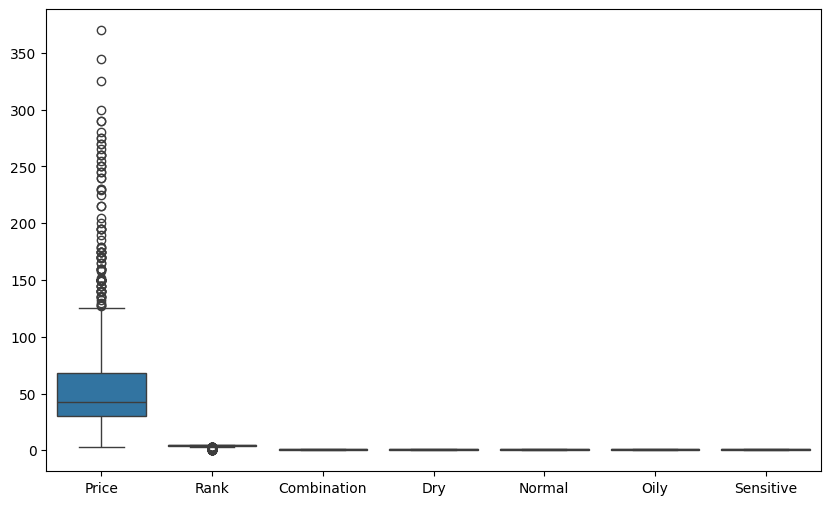

In [9]:
numerical_cols = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10,6))
sns.boxplot(data=data[numerical_cols])
plt.show()

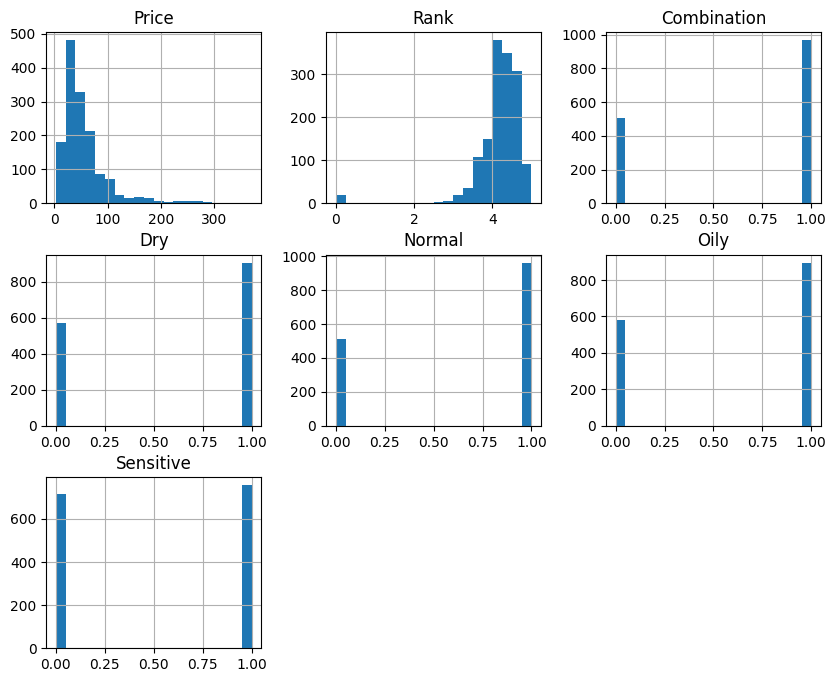

In [10]:
data[numerical_cols].hist(bins=20, figsize=(10, 8))
plt.show()

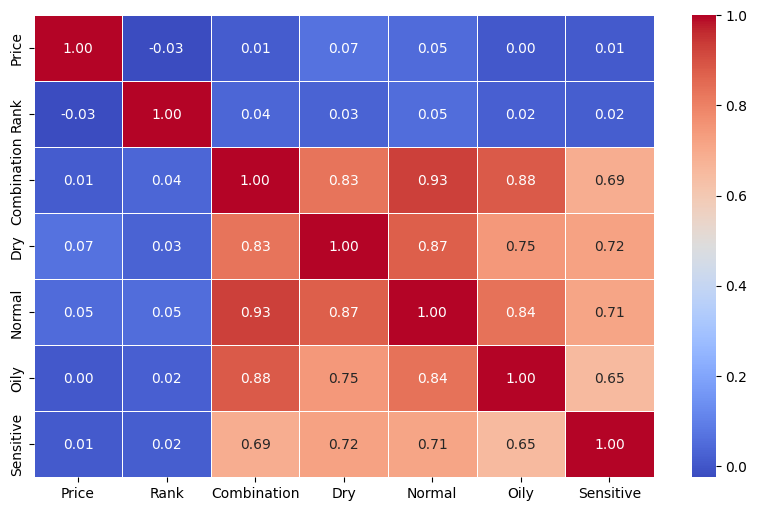

In [11]:
corr = data[numerical_cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

### Data Preprocessing

In [12]:
df['features'] = df['Ingredients']

In [13]:
# Initialize and Transform TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['features'])

In [14]:
# Label Encoding for Classification
df['Label'] = df['Label'].astype('category').cat.codes

In [15]:
# Split Data for Training and Testing
X = tfidf_matrix
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Hyperparameter Tuning for KNN
knn_params = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_model = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
knn_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 10],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [17]:
# Hyperparameter Tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_model = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='accuracy')
rf_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [18]:
# Hyperparameter Tuning for SVM
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_model = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy')
svm_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [19]:
# Evaluate Models
svm_best_model = svm_model.best_estimator_
knn_best_model = knn_model.best_estimator_
rf_best_model = rf_model.best_estimator_

svm_accuracy = accuracy_score(y_test, svm_best_model.predict(X_test))
knn_accuracy = accuracy_score(y_test, knn_best_model.predict(X_test))
rf_accuracy = accuracy_score(y_test, rf_best_model.predict(X_test))

In [20]:
# Define the Recommendation Function
def recommend_cosmetics(skin_type, label_filter, rank_filter, brand_filter, price_range, ingredient_input=None, num_recommendations=10):
    recommended_products = df[df[skin_type] == 1]

    if label_filter != 'All':
        recommended_products = recommended_products[recommended_products['Label'] == label_filter]

    recommended_products = recommended_products[
        (recommended_products['Rank'] >= rank_filter[0]) & 
        (recommended_products['Rank'] <= rank_filter[1])
    ]

    if brand_filter != 'All':
        recommended_products = recommended_products[recommended_products['Brand'] == brand_filter]

    recommended_products = recommended_products[
        (recommended_products['Price'] >= price_range[0]) & 
        (recommended_products['Price'] <= price_range[1])
    ]

    if ingredient_input:
        input_vec = tfidf.transform([ingredient_input])
        cosine_similarities = cosine_similarity(input_vec, tfidf_matrix).flatten()
        recommended_indices = cosine_similarities.argsort()[-num_recommendations:][::-1]
        ingredient_recommendations = df.iloc[recommended_indices]
        recommended_products = recommended_products[recommended_products.index.isin(ingredient_recommendations.index)]

    return recommended_products.sort_values(by=['Rank']).head(num_recommendations)

In [21]:
# Compare Model Performances
print("Model Accuracies:")
print(f"SVM Accuracy: {svm_accuracy}")
print(f"KNN Accuracy: {knn_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")

Model Accuracies:
SVM Accuracy: 0.49491525423728816
KNN Accuracy: 0.4067796610169492
Random Forest Accuracy: 0.5220338983050847


In [22]:
# Sample Recommendation
sample_skin_type = 'Combination'
sample_label_filter = 'All'
sample_rank_filter = (1, 5)
sample_brand_filter = 'All'
sample_price_range = (10, 50)
sample_ingredient_input = 'Aloe Vera, Vitamin E'

recommended_products = recommend_cosmetics(
    sample_skin_type, sample_label_filter, sample_rank_filter, 
    sample_brand_filter, sample_price_range, sample_ingredient_input
)
print("\nRecommended Products:")
print(recommended_products[['Label', 'Brand', 'Name', 'Ingredients', 'Rank']])


Recommended Products:
      Label                Brand  \
1367      4    PETER THOMAS ROTH   
759       5                MURAD   
115       3  YOUTH TO THE PEOPLE   
260       3          JOSIE MARAN   
1329      4    PETER THOMAS ROTH   
841       2           SAND & SKY   
540       0                GO-TO   

                                                   Name  \
1367                             Instant Mineral SPF 45   
759            Pure Skin® Clarifying Dietary Supplement   
115   Superfood Air-Whip Hyaluronic Acid Moisture Cream   
260           Argan Infinity Cream Intensive Creamy Oil   
1329            Max Mineral Naked Broad Spectrum SPF 45   
841           Australian Pink Clay Porefining Face Mask   
540                                 Exfoliating Swipeys   

                                            Ingredients  Rank  
1367  Silica, Aluminum Hydroxide, Stearic Acid, Poly...   3.4  
759   Vitamin A, Vitamin C, Vitamin E, Vitamin B1, V...   4.1  
115   Water, Helianthus